souce and atribution: https://github.com/pintail-xyz/since-the-merge/blob/main/since-the-merge.ipynb

In [ ]:
import requests
import csv
from datetime import timedelta
import math
from random import randrange, random, sample
from datetime import datetime, timedelta
from time import time
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

MERGE_SLOT = 4700013
MERGE_BLOCK = 15537393

In [ ]:
class Ecdf(pd.Series):
    def __init__(self, data):
        s = pd.Series(data)
        super().__init__(s.value_counts().sort_index().cumsum()*1./len(s))
        
    def get_quantile(self, q):
        #self[self.ge(random())].index[0]
        return self.index[np.argmax(self.array >= q)] # faster
        
    def get_scaled_ecdf(self, scaling_factor):
        index = [v * scaling_factor for v in self.index.values]
        scaled_ecdf = self.set_axis(index)
        scaled_ecdf.__class__ = Ecdf
        return scaled_ecdf

start_block = 13136427 # first block of September 2021
end_block = 16112338 # last block of Dec 2022

SECONDS_PER_SLOT = 12

In [ ]:
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom
import numpy as np

EPOCHS_PER_YEAR = 82180
SECONDS_PER_YEAR = 31556952

# define annualised base reward (measured in ETH) for n validators
# assuming all validators have an effective balance of 32 ETH
def annualised_base_reward(n):
    return EPOCHS_PER_YEAR * 512 / math.sqrt(n * 32e9)

# define estimated mean # of blocks proposed per validator per year
# n is the number of active network validators - the average case of pmf
def average_blocks_proposed_per_year(no_of_validators): # mean
    return SECONDS_PER_YEAR / (12 * no_of_validators) # 12 seconds = 1 slot

# Accounting for probability of producing a block
def unluckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.01],31556952/12,1/no_of_validators)

def luckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.99],31556952/12,1/no_of_validators)

avg_mev_reward_per_block = 0.185 # inferring from flashbots activity, we obtain this number by substracting the Flashbots miner tip from the tail gas price multiplied by the gas used by the mined Flashbots bundle.
lower_bound_for_active_staked_eth = 524288 # required for ETH2 to start
upper_bound_for_active_staked_eth = 10e6 # 10M
validators_on_the_network_today = 160000 # may 27
block_selection_frequency_flashbots = 58 # % of blocks seen by Flashbots-enabled miners contains Flashbots bundles


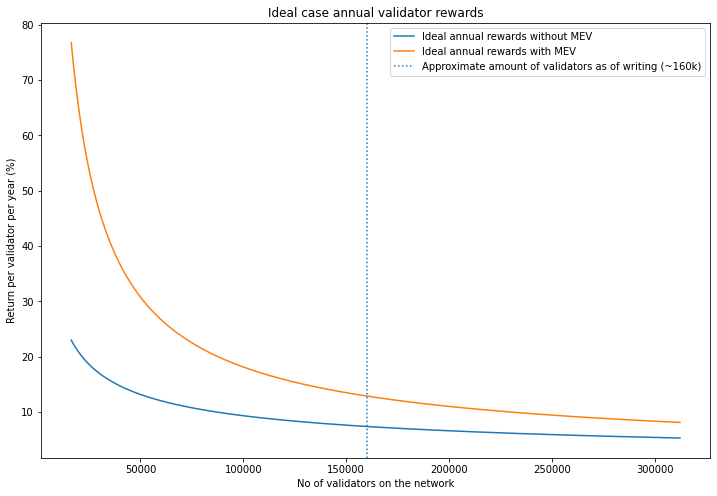

In [ ]:
# Ideal, with and without MEV

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100)) ) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward], label='Ideal annual rewards without MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward_with_mev], label='Ideal annual rewards with MEV')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~160k)")
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
ax.set_title('Ideal case annual validator rewards')
leg = ax.legend()

In [ ]:
# Using graph_objects
import plotly.graph_objects as go

import pandas as pd
fig = go.Figure([go.Scatter(name="ideal_reward", x=n_validators, y=ideal_reward)])
fig.add_trace(go.Scatter(name="ideal_reward_with_mev", x=n_validators, y=ideal_reward_with_mev))
fig.update_layout(
    title="Block Building",
    xaxis_title="n_validators",
    yaxis_title="Blocks per day",
    legend_title="MEV Relay"
)
fig.show()

In [ ]:
# tabulate returns for various amounts of validators with and without MEV
# setup an array of various # of possible active validators
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 160000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network
ideal_reward = [4 * annualised_base_reward(n) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n)  * (block_selection_frequency_flashbots/100))) for n in n_validators]
annual_yield = [100 * r / 32 for r in ideal_reward]
annual_yield_with_mev = [100 * r / 32 for r in ideal_reward_with_mev]
percentage_increase = []
for i in range(len(annual_yield)):
    percentage_increase.append((annual_yield_with_mev[i]/annual_yield[i]-1)*100)
data = {
    '# of validators': n_validators,
    'annual reward (ETH)': ideal_reward,
    'annual reward with mev (ETH)':ideal_reward_with_mev,
    'annual validator yield (%)': annual_yield,
    'annual validator yield with mev (%)': annual_yield_with_mev,
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('# of validators')


,annual reward (ETH),annual reward with mev (ETH),annual validator yield (%),annual validator yield with mev (%)
# of validators,,,,
16384,7.35,24.57,22.97,76.79
50000,4.21,9.85,13.15,30.78
100000,2.98,5.80,9.30,18.12
120000,2.72,5.07,8.49,15.84
150000,2.43,4.31,7.59,13.47
160000,2.35,4.12,7.35,12.86
200000,2.10,3.51,6.57,10.98
250000,1.88,3.01,5.88,9.41
300000,1.72,2.66,5.37,8.31


With 100,000 validators, the mean number of blocks proposed per validator per year is 26.30

The unluckiest 1% of validators will have the opportunity to produce at most 15 blocks in a year
The median (average) validator will have the opportunity to produce 26 blocks in a year
The luckiest 1% of validators will have the opportunity to produce at least 39 blocks in a year


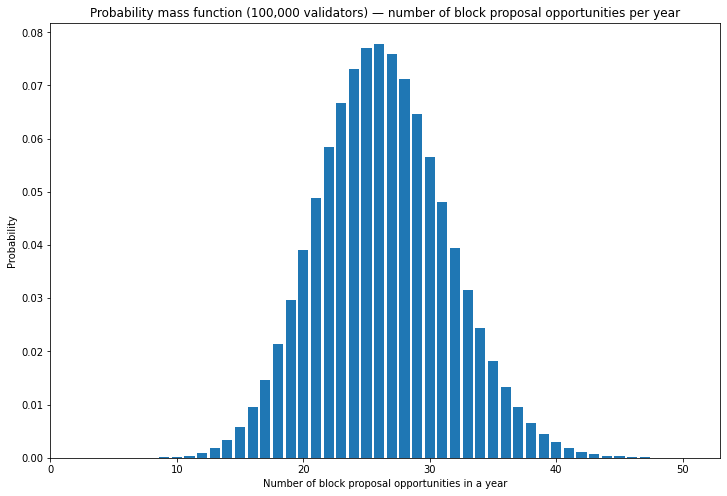

In [ ]:
from scipy.stats import binom

x = [el for el in range(51)]
y = binom.pmf(x, 31556952/12, 1e-5)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x, y)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.set_title('Probability mass function (100,000 validators) — number of block proposal opportunities per year')
ax.set_xlabel('Number of block proposal opportunities in a year')
ax.set_ylabel('Probability')

lmu = binom.ppf([0.01, 0.5, 0.99],31556952/12, 1e-5)
avg = 31556952 / (12 * 100000)
print(f"With 100,000 validators, the mean number of blocks proposed per validator per year is {avg:.2f}\n")
print(f"The unluckiest 1% of validators will have the opportunity to produce at most {int(lmu[0])} blocks in a year")
print(f"The median (average) validator will have the opportunity to produce {int(lmu[1])} blocks in a year")
print(f"The luckiest 1% of validators will have the opportunity to produce at least {int(lmu[2])} blocks in a year")


In [ ]:
# tabulate blocks proposed by unluckiest 1%, median, and luckiest 1% of validators over a year
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network

data = {
    '# of validators': n_validators,
    'unluckiest 1%': [(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators],
    'median':[(binom.ppf(0.5,31556952/12, 1/n)) for n in n_validators],
    'luckiest 1%': [(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('# of validators')

,unluckiest 1%,median,luckiest 1%
# of validators,,,
16384,132.00,160.00,191.00
50000,36.00,52.00,70.00
100000,15.00,26.00,39.00
120000,12.00,22.00,33.00
150000,9.00,17.00,28.00
200000,6.00,13.00,22.00
250000,4.00,10.00,19.00
300000,3.00,9.00,16.00
312500,3.00,8.00,16.00


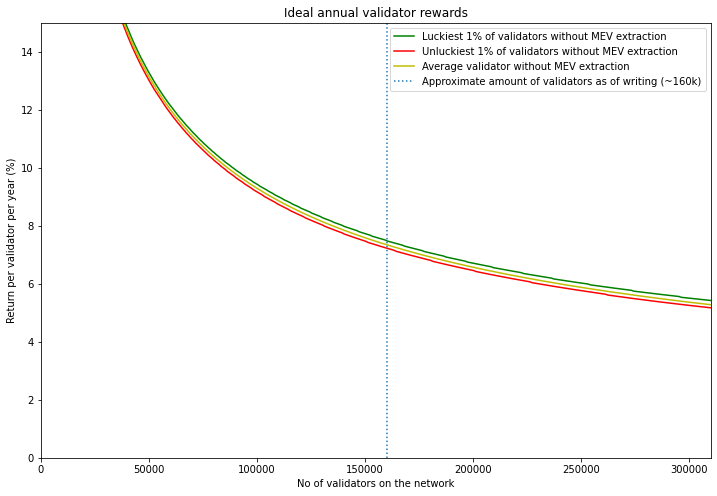

In [ ]:
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))
# 3rd parameter below sets the color: https://matplotlib.org/stable/tutorials/colors/colors.html
# green => luckiest, red => unluckiest, yellow => average
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , 'g', label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], 'r', label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], 'y', label='Average validator without MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~160k)")
ax.set_title('Ideal annual validator rewards')
# Set limits on X/Y axis
axes = plt.gca()
axes.set_xlim([0,310000]) #min, max
axes.set_ylim([0,15])
leg = ax.legend();

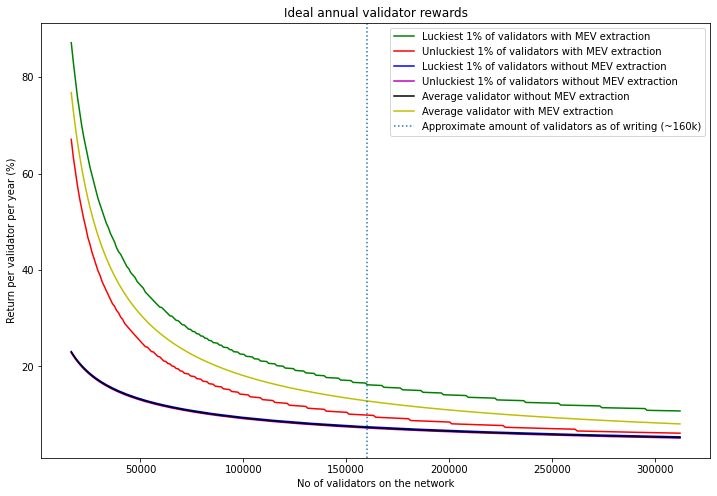

In [ ]:
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , 'g', label='Luckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], 'r', label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , 'b', label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], 'm', label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], 'k', label='Average validator without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], 'y', label='Average validator with MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~160k)")
ax.set_title('Ideal annual validator rewards')
#ax.set_yscale("log")
# Set limits on X/Y axis
leg = ax.legend();



## MEV

In [16]:
import requests
from statistics import median

SECONDS_PER_YEAR = 31556952
BEACON_CHAIN_GENESIS_TIMESTAMP = 1606824023

class Ecdf(pd.Series):
    def __init__(self, data):
        s = pd.Series(data)
        super().__init__(s.value_counts().sort_index().cumsum()*1./len(s))

    def get_quantile(self, q):
        return self.index[np.argmax(self.array >= q)]

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/pintail-xyz/since-the-merge/main/proposers.csv')

In [ ]:
data['slot'] = [int(item) for item in data['slot']]
data['val_index'] = [int(item) for item in data['val_index']]
data['net_fees'] = [0 if item == '' else float(item) for item in data['net_fees']]
data['coinbase_transfer'] = [0 if item == '' else float(item) for item in data['coinbase_transfer']]

blocks_df = pd.DataFrame(data)

In [ ]:
blocks_df

,slot,val_index,block_number,net_fees,coinbase_transfer,fee_recipient,builder_payee
0,4700013,347963,"15,537,394.00","45,031,378,244,766,392,320.00",0.00,0xeee27662c2b8eba3cd936a23f039f3189633e4c8,0xeee27662c2b8eba3cd936a23f039f3189633e4c8
1,4700014,94503,"15,537,395.00","792,354,021,024,614,912.00",0.00,0x0b3b161b8abeb6b04cb95c3e6047f80c120a0292,0x0b3b161b8abeb6b04cb95c3e6047f80c120a0292
2,4700015,330818,"15,537,396.00","1,209,554,924,314,136,576.00",0.00,0x388c818ca8b9251b393131c08a736a67ccb19297,0x388c818ca8b9251b393131c08a736a67ccb19297
3,4700016,81113,"15,537,397.00","394,115,963,505,827,968.00",0.00,0xe688b84b23f322a994a53dbf8e15fa82cdb71127,0xe688b84b23f322a994a53dbf8e15fa82cdb71127
4,4700017,194406,"15,537,398.00","1,544,313,903,803,763,200.00",0.00,0x535b918f3724001fd6fb52fcc6cbc220592990a3,0x535b918f3724001fd6fb52fcc6cbc220592990a3
...,...,...,...,...,...,...,...
302394,5002407,302224,"15,837,687.00","89,056,047,728,548,592.00","4,319,967,539,451,932.00",0x690b9a9e9aa1c9db991c7721a92d351db4fac990,0x388c818ca8b9251b393131c08a736a67ccb19297
302395,5002408,108613,"15,837,688.00","209,086,019,028,283,648.00","71,319,522,467,330,656.00",0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,0x388c818ca8b9251b393131c08a736a67ccb19297
302396,5002409,229979,"15,837,689.00","2,362,569,228,157,185.00",0.00,0x6d2e03b7effeae98bd302a9f836d0d6ab0002766,0x6d2e03b7effeae98bd302a9f836d0d6ab0002766
302397,5002410,12248,"15,837,690.00","74,060,791,233,877,168.00","1,570,146,394,300,000.00",0xba9431d1975b5131e496f8398d6e6b4e4a08fd05,0xba9431d1975b5131e496f8398d6e6b4e4a08fd05


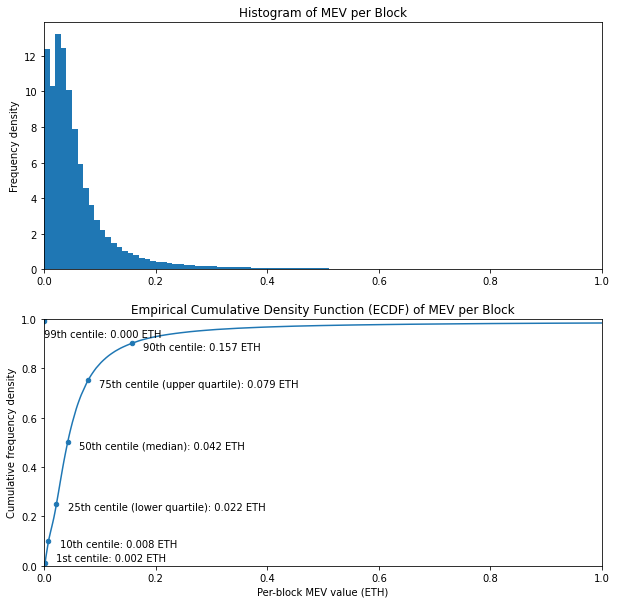

,centile (%),revenue (ETH per block)
quantile,,
0.01,1.0,0.002
0.1,10.0,0.008
0.25,25.0,0.022
0.5,50.0,0.042
0.75,75.0,0.079
0.9,90.0,0.157
0.99,99.0,0.000
0.999,99.9,0.000


In [ ]:
# plot ECDF, show quantiles for block value

blocks_df['block_value'] = (blocks_df['net_fees'] + blocks_df['coinbase_transfer']) / 1e18
blocks_ecdf = Ecdf(blocks_df['block_value'])

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

bins = [e/100 for e in range(101)]
blocks_df['block_value'].hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title('Histogram of MEV per Block')
ax1.set_xlim(0, 1)
ax1.set_ylabel('Frequency density')

quantiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]
table = pd.DataFrame({'quantile': quantiles, 'centile (%)': [100 * q for q in quantiles],'revenue (ETH per block)': [blocks_ecdf.get_quantile(q) for q in quantiles]
})

table.set_index('quantile', inplace=True, drop=False)
table.plot('revenue (ETH per block)', 'quantile', kind='scatter', ax=ax2)

blocks_ecdf.plot(ax=ax2)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Per-block MEV value (ETH)')
ax2.set_ylabel('Cumulative frequency density')
ax2.set_title('Empirical Cumulative Density Function (ECDF) of MEV per Block')
q01 = table['revenue (ETH per block)'].loc[0.01]
ax2.annotate(f'1st centile: {q01:.3f} ETH', (q01 + 0.02, 0.02))
q1 = table['revenue (ETH per block)'].loc[0.1]
ax2.annotate(f'10th centile: {q1:.3f} ETH', (q1 + 0.02, 0.075))
q25 = table['revenue (ETH per block)'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {q25:.3f} ETH', (q25 + 0.02, 0.225))
q5 = table['revenue (ETH per block)'].loc[0.5]
ax2.annotate(f'50th centile (median): {q5:.3f} ETH', (q5 + 0.02, 0.475))
q75 = table['revenue (ETH per block)'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {q75:.3f} ETH', (q75 + 0.02, 0.725))
q9 = table['revenue (ETH per block)'].loc[0.9]
ax2.annotate(f'90th centile: {q9:.3f} ETH', (q9 + 0.02, 0.875))
q99 = table['revenue (ETH per block)'].loc[0.99]
ax2.annotate(f'99th centile: {q99:.3f} ETH', (q99, 0.925))

plt.show()
table[['centile (%)', 'revenue (ETH per block)']].style.set_table_styles(
[dict(selector='th', props=[('text-align', 'center')])]).format({'centile (%)': '{:.1f}', 'revenue (ETH per block)': '{:.3f}'}
)


##Block builders

In [ ]:
# calculate daily builder counts, totals and mean block values

# load validator/balance data

start_slot = blocks_df['slot'].min()
end_slot = blocks_df['slot'].max()

def get_slot_datetime(slot):
    return datetime.utcfromtimestamp(BEACON_CHAIN_GENESIS_TIMESTAMP + 12 * slot)

builders = { # top builders by blocks in this dataset (based on tags from Etherscan)
    '0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5': 'flashbots',
    '0xb64a30399f7f6b0c154c2e7af0a3ec7b0a5b131a': 'flashbots',
    '0x690b9a9e9aa1c9db991c7721a92d351db4fac990': 'builder0x69.io',
    '0xf2f5c73fa04406b1995e397b55c24ab1f3ea726c': 'bloxroute max profit',
    '0x199d5ed7f45f4ee35960cf22eade2076e95b253f': 'bloxroute regulated',
    '0xf573d99385c05c23b24ed33de616ad16a43a0919': 'bloxroute ethical',
    '0xb646d87963da1fb9d192ddba775f24f33e857128': '0xb646',
    '0xaab27b150451726ec7738aa1d0a94505c8729bd1': 'eden network',
}

keys = {'self built': 0, 'other builder': 0}
for _, v in builders.items():
    keys[v] = 0

start_date = get_slot_datetime(start_slot).date()
end_date = get_slot_datetime(end_slot).date()
#end_date = end_date.replace(2022, 12, 4)
num_days = (end_date - start_date).days + 1

daily_builder_counts, daily_builder_totals, daily_builder_mean, daily_builder_median = [], [], [], []
for i in range(num_days):
    daily_builder_counts.append({'date': start_date + timedelta(days=i)})
    daily_builder_totals.append({'date': start_date + timedelta(days=i)})
    daily_builder_mean.append({'date': start_date + timedelta(days=i)})
    daily_builder_median.append({'date': start_date + timedelta(days=i)})
    for k in keys:
        daily_builder_counts[-1][k] = 0
        daily_builder_totals[-1][k] = 0
        daily_builder_mean[-1][k] = 0
        daily_builder_median[-1][k] = []

# count blocks produced by each builder each day, and sum total block values
for index, row in blocks_df.iterrows():
    day = (get_slot_datetime(row['slot']).date() - start_date).days
    if row['fee_recipient'] in builders:
        builder = builders[row['fee_recipient']]
    elif row['fee_recipient'] != row['builder_payee']:
        builder = 'other builder'
    else:
        builder = 'self built'
    daily_builder_counts[day][builder] += 1
    daily_builder_totals[day][builder] += row['block_value']
    daily_builder_median[day][builder].append(row['block_value'])

# calculate mean block value for each builder each day
for day, mean in enumerate(daily_builder_mean):
    for k in mean:
        if k == 'date':
            continue
        if daily_builder_counts[day][k] == 0:
            mean[k] = None
        else:
            mean[k] = daily_builder_totals[day][k] / daily_builder_counts[day][k]

# calculate median block value for each builder each day
for day, values in enumerate(daily_builder_median):
    for k in values:
        if k == 'date':
            continue
        if len(daily_builder_median[day][k]) == 0:
            values[k] = None
        else:
            values[k] = median(values[k])

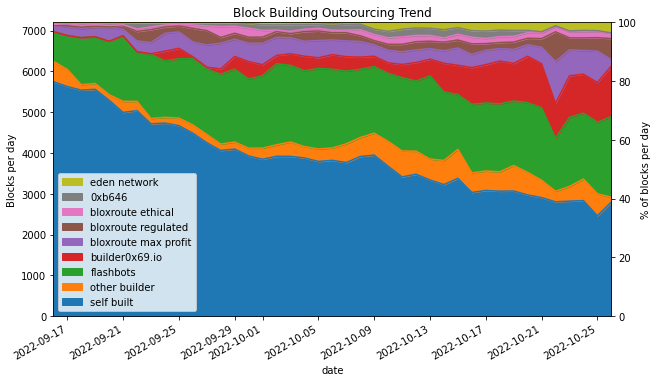

Self-built blocks (2022-09-16): 79.8%
Self-built blocks (2022-10-26): 38.9%


In [ ]:
daily_builder_counts_df = pd.DataFrame(daily_builder_counts)
daily_builder_counts_df.set_index('date', inplace=True, drop=False)

fig, ax = plt.subplots(figsize=(10, 6))
daily_builder_counts_df.plot.area(ax=ax)
ax.set_xlim(
    daily_builder_counts_df['date'][1],
    daily_builder_counts_df['date'][-2]
)
blocks_per_day = 60 * 60 * 24 / 12
ax.set_ylim(0, blocks_per_day)
secax = ax.secondary_yaxis('right', functions=(
    lambda k: 100 * k / blocks_per_day, lambda k: k * blocks_per_day / 100
))
secax.set_ylabel('% of blocks per day')
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_ylabel('Blocks per day')
ax.set_title('Block Building Outsourcing Trend')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower left')
plt.show()

print(
    f"Self-built blocks ({daily_builder_counts_df['date'][1]}): "
    f"{100 * daily_builder_counts_df['self built'][1] / blocks_per_day:.1f}%"
)
print(
    f"Self-built blocks ({daily_builder_counts_df['date'][-2]}): "
    f"{100 * daily_builder_counts_df['self built'][-2] / blocks_per_day:.1f}%"
)

In [ ]:
daily_builder_counts_df
daily_builder_counts_df.drop(['date'], axis=1)

,self built,other builder,flashbots,builder0x69.io,bloxroute max profit,bloxroute regulated,bloxroute ethical,0xb646,eden network
date,,,,,,,,,
2022-09-15,4454,244,370,0,50,8,6,50,4
2022-09-16,5748,498,726,0,162,0,15,50,1
2022-09-17,5628,419,833,0,212,24,52,27,5
2022-09-18,5539,132,1155,0,218,37,50,65,4
2022-09-19,5559,144,1145,0,234,26,35,56,1
2022-09-20,5293,135,1310,0,343,16,29,71,3
2022-09-21,4993,272,1609,0,155,89,24,47,11
2022-09-22,5037,228,1206,12,261,234,58,157,7
2022-09-23,4714,130,1572,17,272,317,68,106,4


In [ ]:
# Using graph_objects
import plotly.graph_objects as go

import pandas as pd
fig = go.Figure([go.Scatter(name="self built", x=daily_builder_counts_df['date'], y=daily_builder_counts_df['self built'])])
fig.add_trace(go.Scatter(name="flashbots", x=daily_builder_counts_df['date'], y=daily_builder_counts_df["flashbots"]))
fig.add_trace(go.Scatter(name="bloxroute max profit", x=daily_builder_counts_df['date'], y=daily_builder_counts_df["bloxroute max profit"]))
fig.add_trace(go.Scatter(name="bloxroute regulated", x=daily_builder_counts_df['date'], y=daily_builder_counts_df["bloxroute regulated"]))
fig.update_layout(
    title="Block Building",
    xaxis_title="date",
    yaxis_title="Blocks per day",
    legend_title="MEV Relay"
)
fig.show()


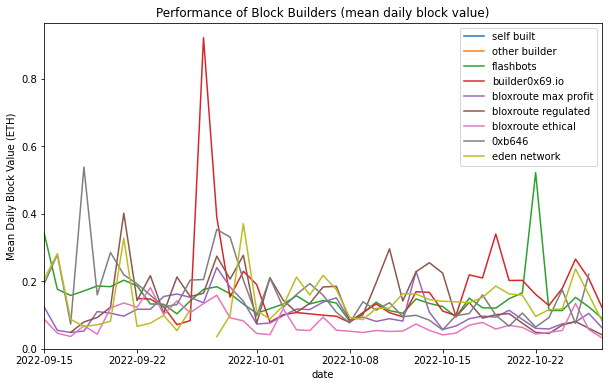

In [ ]:
daily_builder_mean_df = pd.DataFrame(daily_builder_mean)
daily_builder_mean_df.set_index('date', inplace=True, drop=False)

fig, ax = plt.subplots(figsize=(10, 6))
daily_builder_mean_df.plot(ax=ax)
ax.set_title('Performance of Block Builders (mean daily block value)')
ax.set_ylabel('Mean Daily Block Value (ETH)')
ax.set_xlim(
    daily_builder_mean_df['date'][0],
    daily_builder_mean_df['date'][-1]
)
ax.set_ylim(ymin=0);

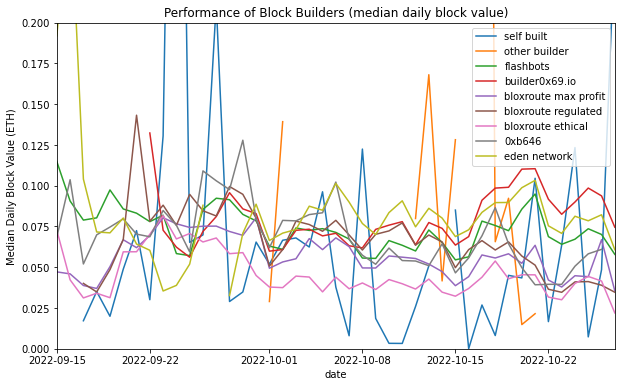

In [ ]:
daily_builder_median_df = pd.DataFrame(daily_builder_median)
daily_builder_median_df.set_index('date', inplace=True, drop=False)

fig, ax = plt.subplots(figsize=(10, 6))
daily_builder_median_df.plot(ax=ax)
ax.set_title('Performance of Block Builders (median daily block value)')
ax.set_ylabel('Median Daily Block Value (ETH)')
ax.set_xlim(
    daily_builder_median_df['date'][0],
    daily_builder_median_df['date'][-1]
)
ax.set_ylim(0, 0.2);

In [ ]:
# Using graph_objects
import plotly.graph_objects as go

import pandas as pd
fig = go.Figure([go.Scatter(name="self built", x=daily_builder_median_df['date'], y=daily_builder_median_df['self built'])])
fig.add_trace(go.Scatter(name="flashbots", x=daily_builder_median_df['date'], y=daily_builder_median_df["flashbots"]))
fig.add_trace(go.Scatter(name="bloxroute max profit", x=daily_builder_median_df['date'], y=daily_builder_median_df["bloxroute max profit"]))
fig.add_trace(go.Scatter(name="bloxroute regulated", x=daily_builder_median_df['date'], y=daily_builder_median_df["bloxroute regulated"]))
fig.update_layout(
    title="Performance of Block Builders (median daily block value)",
    xaxis_title="date",
    yaxis_title="Median Daily Block Value (ETH)",
    legend_title="MEV Relay"
)
fig.show()